In [63]:
import manganite
%load_ext manganite

The manganite extension is already loaded. To reload it, use:
  %reload_ext manganite


# Portfolio Selection Optimization
This model is an example of the classic [Markowitz portfolio selection optimization model](https://en.wikipedia.org/wiki/Markowitz_model). We want to find the fraction of the portfolio to invest among a set of stocks that balances risk and return. It is a Quadratic Programming (QP) model with vector and matrix data for returns and risk, respectively. This is best suited to a matrix formulation, so we use the Gurobi Python *matrix* interface. The basic model is fairly simple, so we also solve it parametrically to find the efficient frontier.

**Download the Repository** <br /> 
You can download the repository containing this and other examples by clicking [here](https://github.com/Gurobi/modeling-examples/archive/master.zip). 

**Gurobi License** <br /> 
In order to run this Jupyter Notebook properly, you must have a Gurobi license. If you do not have one, you can request an [evaluation license](https://www.gurobi.com/downloads/request-an-evaluation-license/?utm_source=3PW&utm_medium=OT&utm_campaign=WW-MU-MUI-OR-O_LEA-PR_NO-Q3_FY20_WW_JPME_Lost_Luggage_Distribution_COM_EVAL_GitHub&utm_term=Lost%20Luggage%20Distribution&utm_content=C_JPM) as a *commercial user*, or download a [free license](https://www.gurobi.com/academia/academic-program-and-licenses/?utm_source=3PW&utm_medium=OT&utm_campaign=WW-MU-EDU-OR-O_LEA-PR_NO-Q3_FY20_WW_JPME_Lost_Luggage_Distribution_COM_EVAL_GitHub&utm_term=Lost%20Luggage%20Distribution&utm_content=C_JPM) as an *academic user*.


## Model Formulation
### Parameters

We use the [Greek values](https://en.wikipedia.org/wiki/Greeks_\(finance\)) that are traditional in finance:

- $\delta$: n-element vector measuring the change in price for each stock
- $\sigma$: n x n matrix measuring the covariance among stocks

There is one additional parameter when solving the model parametrically:

- r: target return


### Decision Variables
- $x \ge 0$: n-element vector where each element represents the fraction of the porfolio to invest in each stock

### Objective Function
Minimize the total risk, a convex quadratic function:

\begin{equation}
\min x^t \cdot \sigma \cdot x
\end{equation}

### Constraints

Allocate the entire portfolio: the total investments should be 1.0 (100%), where $e$ is a unit vector (all 1's):

\begin{equation}
e \cdot x = 1
\end{equation}


Return: When we solve the model parametrically for different return values $r$, we add a constraint on the target return:

\begin{equation}
\delta \cdot x = r
\end{equation}

## Python Implementation
### Stock data
Use [yfinance](https://pypi.org/project/yfinance/) library to get the latest 2 years of _actual stock data_ from the 20 most profitable US companies, [according to Wikipedia in April 2021](https://en.wikipedia.org/wiki/List_of_largest_companies_in_the_United_States_by_revenue#List_of_companies_by_profit).

In [64]:
import yfinance as yf
import numpy as np

import gurobipy as gp
from gurobipy import GRB
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt


In [65]:
%%mnn widget --type checkbox --tab "Stock Selector" --header "Apple" --var AAPL
AAPL = True

In [66]:
%%mnn widget --type checkbox --tab "Stock Selector" --header "Microsoft" --var MSFT
MSFT = True

In [67]:
%%mnn widget --type checkbox --tab "Stock Selector" --header "JPMorgan" --var JPM
JPM = True

In [68]:
%%mnn widget --type checkbox --tab "Stock Selector" --header "Google" --var GOOG
GOOG = False

In [69]:
%%mnn widget --type checkbox --tab "Stock Selector" --header "Bank of America" --var BAC
BAC = True

In [71]:
%%mnn widget --type checkbox --tab "Stock Selector" --header "Intel" --var INTC
INTC = True

In [72]:
stocks_dict = {'AAPL':AAPL, 'MSFT':MSFT, 'JPM':JPM, 'GOOG':GOOG, 'INTC': INTC, 'BAC':BAC}
stocks =[]
for key,value in stocks_dict.items():
    if value:
        stocks.append(key)

data = yf.download(stocks, period='2y')

[*********************100%%**********************]  5 of 5 completed


### Compute Greeks
Using the downloaded stock data, find the delta (return), sigma (covariance) and standard deviation values for stock prices:

In [73]:
# import numpy as np

closes = np.transpose(np.array(data.Close)) # matrix of daily closing prices
absdiff = np.diff(closes)                   # change in closing price each day
reldiff = np.divide(absdiff, closes[:,:-1]) # relative change in daily closing price
delta = np.mean(reldiff, axis=1)            # mean price change
sigma = np.cov(reldiff)                     # covariance (standard deviations)
std = np.std(reldiff, axis=1)               # standard deviation

## Minimize risk by solving QP model

In [74]:
%%mnn execute --on button "Optimize Portfolio" --returns optimisation_done

print('solving QP model')
# Create an empty model
m = gp.Model('portfolio')

# Add matrix variable for the stocks
x = m.addMVar(len(stocks))

# Objective is to minimize risk (squared).  This is modeled using the
# covariance matrix, which measures the historical correlation between stocks
portfolio_risk = x @ sigma @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)

# Fix budget with a constraint
m.addConstr(x.sum() == 1, 'budget')

# Verify model formulation
# m.write('portfolio_selection_optimization.lp')

# Optimize model to find the minimum risk portfolio
m.optimize()

optimisation_done = 1

minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X

# Create an expression representing the expected return for the portfolio
portfolio_return = delta @ x
target = m.addConstr(portfolio_return == minrisk_return, 'target')

# Solve for efficient frontier by varying target return
frontier = np.empty((2,0))
for r in np.linspace(delta.min(), delta.max(), 25):
    target.rhs = r
    m.optimize()
    frontier = np.append(frontier, [[sqrt(m.ObjVal)],[r]], axis=1)


solving QP model
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0xb2eab458
Model has 15 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-04, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 5 columns, 5 nonzeros
Presolved model has 15 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 4
 AA' NZ     : 1.000e+01
 Factor NZ  : 1.500e+01
 Factor Ops : 5.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.70135573e+05 -3.70135573e+05  4.18e+03 6.01e-04  9.98e+05     0s
   1   2.002

## Display minimum risk portfolio using Pandas

In [75]:
%%mnn widget --type table --tab "Portfolio" --position 0 0 6 --header "Minimal risk portfolio" --var df_min
df_min = pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
             index=stocks + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])

In [76]:
df_min

,Minimum Risk Portfolio
AAPL,1.000000e+00
MSFT,1.027096e-14
JPM,8.356071e-14
INTC,1.011252e-14
BAC,1.779005e-13
Volatility,1.868862e-02
Expected Return,5.414479e-04


## Compute the efficient frontier
Solve the QP parametrically to find the lowest risk portfolio for different expected returns.

## Plot results
Use the matplot library to plot the optimized solutions, along with the individual stocks:

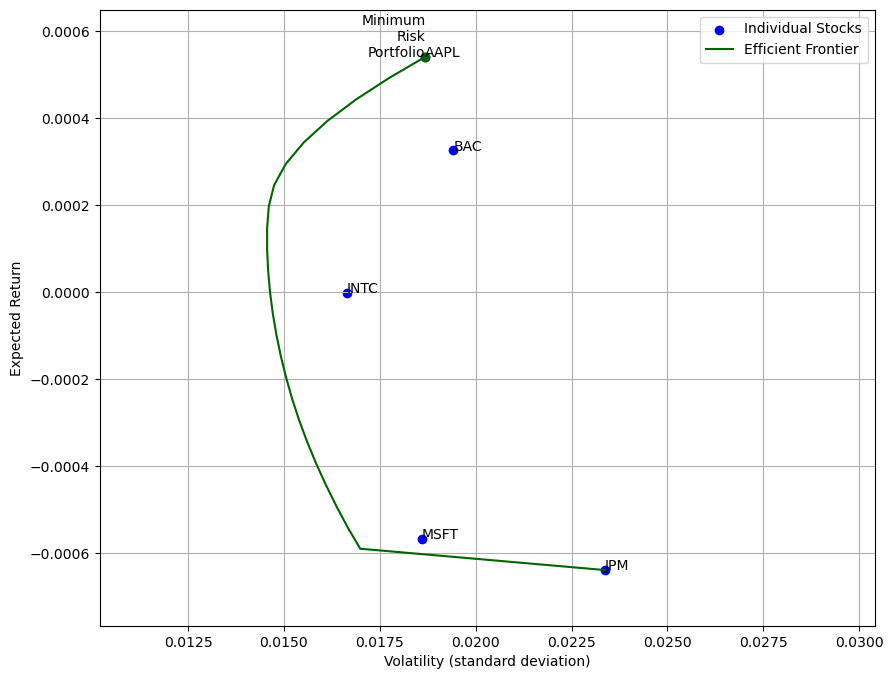

In [77]:
%%mnn widget --type plot --var fig --tab "Efficient frontier" --position -1 0 6 --header "optimized solution"


fig, ax = plt.subplots(figsize=(10,8))

# Plot volatility versus expected return for individual stocks
ax.scatter(x=std, y=delta,
           color='Blue', label='Individual Stocks')
for i, stock in enumerate(stocks):
    ax.annotate(stock, (std[i], delta[i]))

# Plot volatility versus expected return for minimum risk portfolio
ax.scatter(x=minrisk_volatility, y=minrisk_return, color='DarkGreen')
ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility, minrisk_return),
            horizontalalignment='right')

# Plot efficient frontier
ax.plot(frontier[0], frontier[1], label='Efficient Frontier', color='DarkGreen')

# Format and display the final plot
ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, delta.min()*1.2, delta.max()*1.2])
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Return')
ax.legend()
ax.grid()
# plt.show()